In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Load the datasets
# customer_data contains demographic and category features, while payment_data holds payment history
customer_data = pd.read_csv("data\customer_data.csv")
payment_data = pd.read_csv("data\payment_data.csv")

customer_data

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0,58988196,5,1289.0,1,173000.0,2,15,5,112,3,350702,200.000000
1121,0,58987926,5,NaN,2,50000.0,2,15,5,108,4,450000,169.000000
1122,0,58995381,7,1220.0,3,76000.0,2,11,2,90,5,71002,1.000000
1123,0,58998054,4,1250.0,3,137000.0,2,8,5,90,5,72000,1.000000


In [2]:
payment_data

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016
...,...,...,...,...,...,...,...,...,...,...,...,...
8245,58995478,0,0,0,0,9,15,NaN,NaN,0.0,NaN,NaN
8246,54992408,0,0,0,0,1,2,NaN,NaN,0.0,NaN,NaN
8247,54988209,0,0,0,0,5,13,NaN,NaN,20654.4,33315.0,NaN
8248,54992408,0,0,0,0,1,2,NaN,NaN,0.0,NaN,NaN


In [3]:

# Merge both datasets on 'id' to bring together customer details and payment history
merged_data = pd.merge(customer_data, payment_data, on='id', how='left')

# Handling missing values where necessary
merged_data.loc[:, 'fea_2'] = merged_data['fea_2'].fillna(merged_data['fea_2'].median())
merged_data.loc[:, 'prod_limit'] = merged_data['prod_limit'].fillna(merged_data['prod_limit'].median())
merged_data.loc[:, 'highest_balance'] = merged_data['highest_balance'].fillna(merged_data['new_balance'])

# Feature Engineering: Creating new financial indicators
# - Credit Utilization Ratio: Measures how much credit is used compared to the limit
# - Overdue Payment Frequency: Tracks how often payments are overdue
# - Debt Burden Ratio: Measures the proportion of debt relative to income
merged_data['credit_utilization_ratio'] = merged_data['new_balance'] / merged_data['prod_limit']
merged_data['overdue_payment_frequency'] = (merged_data['OVD_t1'] + merged_data['OVD_t2'] + merged_data['OVD_t3']) / (merged_data['pay_normal'] + 1)  # Adding 1 to avoid division by zero
merged_data['debt_burden_ratio'] = merged_data['new_balance'] / merged_data['fea_10']

# Selecting the features we want to use for training our model
features = ['credit_utilization_ratio', 'overdue_payment_frequency', 'debt_burden_ratio', 
            'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11']
X = merged_data[features]  # Independent variables
y = merged_data['label']   # Target variable (1 = high risk, 0 = low risk)



In [4]:
# Splitting the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Some models (like Logistic Regression) work better with standardized data, so we scale it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing our machine learning models
log_reg = LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42)  # Logistic Regression for baseline performance
decision_tree = DecisionTreeClassifier(random_state=42)  # Decision Tree for non-linear decision making
xgb = XGBClassifier(eval_metric='logloss', random_state=42)  # XGBoost for more advanced boosting-based predictions

# Training all three models
log_reg.fit(X_train_scaled, y_train)
decision_tree.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Making predictions using our trained models
log_reg_preds = log_reg.predict(X_test_scaled)
decision_tree_preds = decision_tree.predict(X_test)
xgb_preds = xgb.predict(X_test)

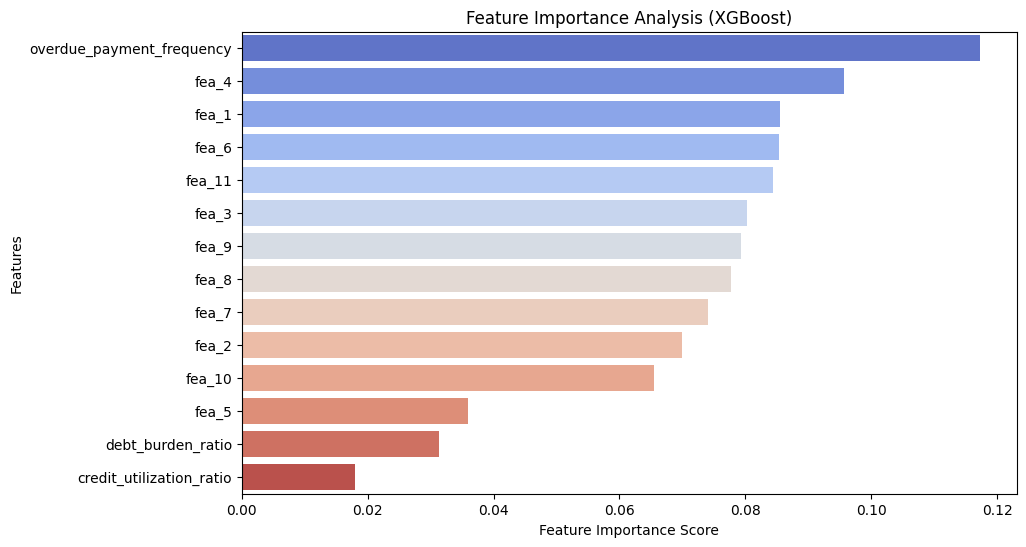

In [5]:
# Function to evaluate model performance using common classification metrics
def evaluate_model(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }

# Collecting results from all three models
results = [
    evaluate_model(y_test, log_reg_preds, "Logistic Regression"),
    evaluate_model(y_test, decision_tree_preds, "Decision Tree"),
    evaluate_model(y_test, xgb_preds, "XGBoost")
]

# Displaying the model performance comparison
results_df = pd.DataFrame(results)
#print(results_df)

# Analyzing which features were the most important in the XGBoost model
importances = xgb.feature_importances_
feature_names = X_train.columns

# Visualizing feature importance in XGBoost
sorted_indices = np.argsort(importances)[::-1]  # Sorting features by importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=np.array(feature_names)[sorted_indices], hue=np.array(feature_names)[sorted_indices], palette="coolwarm", legend=False)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance Analysis (XGBoost)")
plt.show()

In [6]:
# Selecting the features we want to use for training our model
features = ['credit_utilization_ratio', 'overdue_payment_frequency', 'debt_burden_ratio', 
            ]
X = merged_data[features]  # Independent variables

In [7]:
# Splitting the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Some models (like Logistic Regression) work better with standardized data, so we scale it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing our machine learning models
log_reg = LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42)  # Logistic Regression for baseline performance
decision_tree = DecisionTreeClassifier(random_state=42)  # Decision Tree for non-linear decision making
xgb = XGBClassifier(eval_metric='logloss', random_state=42)  # XGBoost for more advanced boosting-based predictions

# Training all three models
log_reg.fit(X_train_scaled, y_train)
decision_tree.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Making predictions using our trained models
log_reg_preds = log_reg.predict(X_test_scaled)
decision_tree_preds = decision_tree.predict(X_test)
xgb_preds = xgb.predict(X_test)

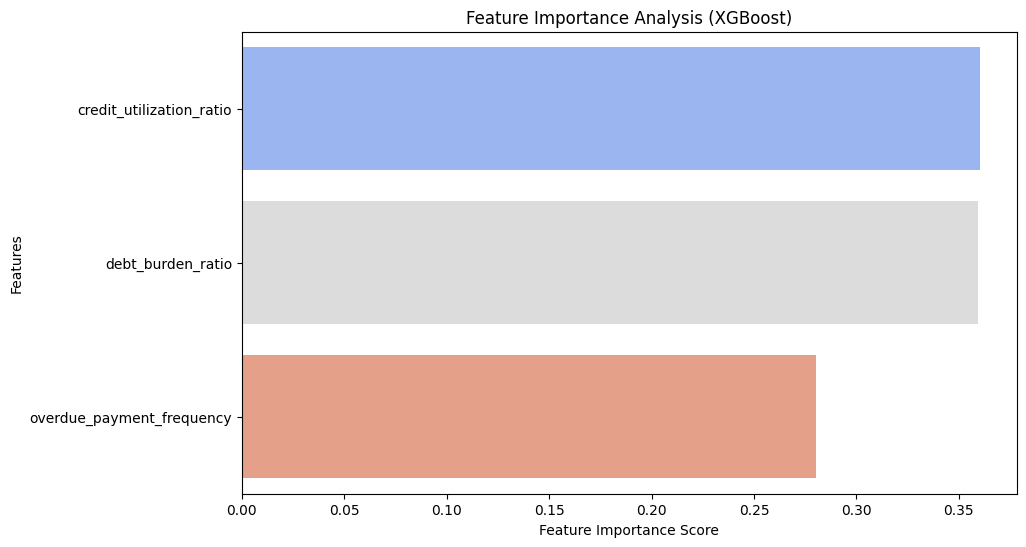

In [8]:
# Function to evaluate model performance using common classification metrics
def evaluate_model(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }

# Collecting results from all three models
results2 = [
    evaluate_model(y_test, log_reg_preds, "Logistic Regression"),
    evaluate_model(y_test, decision_tree_preds, "Decision Tree"),
    evaluate_model(y_test, xgb_preds, "XGBoost")
]

# Displaying the model performance comparison
results_df2 = pd.DataFrame(results2)
#print(results_df)

# Analyzing which features were the most important in the XGBoost model
importances = xgb.feature_importances_
feature_names = X_train.columns

# Visualizing feature importance in XGBoost
sorted_indices = np.argsort(importances)[::-1]  # Sorting features by importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=np.array(feature_names)[sorted_indices], hue=np.array(feature_names)[sorted_indices], palette="coolwarm", legend=False)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance Analysis (XGBoost)")
plt.show()

In [14]:
print("Results with categorical (demographic) variables:\n", results_df)
print("\n \nResults without categorical (demographic) variables:\n", results_df2)

Results with categorical (demographic) variables:
                  Model  Accuracy  Precision    Recall   ROC-AUC
0  Logistic Regression  0.832727   0.666667  0.007220  0.503246
1        Decision Tree  0.983030   0.956044  0.942238  0.966749
2              XGBoost  0.989697   0.996183  0.942238  0.970755

 
Results without categorical (demographic) variables:
                  Model  Accuracy  Precision    Recall   ROC-AUC
0  Logistic Regression  0.832727   1.000000  0.003610  0.501805
1        Decision Tree  0.776364   0.201299  0.111913  0.511164
2              XGBoost  0.822424   0.214286  0.021661  0.502819


In [15]:
# Save the cleaned dataset with model predictions
merged_data['LogReg_Prediction'] = log_reg.predict(X)
merged_data['DecisionTree_Prediction'] = decision_tree.predict(X)
merged_data['XGBoost_Prediction'] = xgb.predict(X)

merged_data.to_csv("data/credit_risk_predictions.csv", index=False)

# Save model performance results
results_df.to_csv("data/model_performance.csv", index=False)
results_df2.to_csv("data/model_performance_nocat.csv", index=False)

# Save feature importance from XGBoost
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_importance_df.to_csv("data/feature_importance.csv", index=False)


C:\Users\coope\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
